In [1]:
# !pip install autokeras


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist

import autokeras as ak


In this tutorial, we show how to customize your search space with
[AutoModel](/auto_model/#automodel-class) and how to implement your own block
as search space.  This API is mainly for advanced users who already know what
their model should look like.

## Customized Search Space
First, let us see how we can build the following neural network using the
building blocks in AutoKeras.

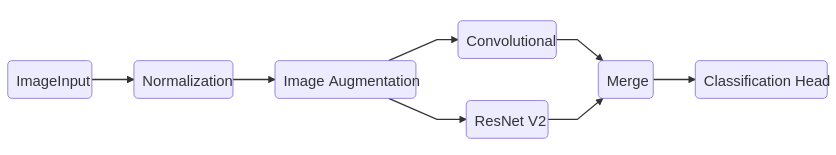

<div class="mermaid">
graph LR
    id1(ImageInput) --> id2(Normalization)
    id2 --> id3(Image Augmentation)
    id3 --> id4(Convolutional)
    id3 --> id5(ResNet V2)
    id4 --> id6(Merge)
    id5 --> id6
    id6 --> id7(Classification Head)
</div>

We can make use of the [AutoModel](/auto_model/#automodel-class) API in
AutoKeras to implemented as follows.
The usage is the same as the [Keras functional
API](https://www.tensorflow.org/guide/keras/functional).
Since this is just a demo, we use small amount of `max_trials` and `epochs`.


In [4]:

input_node = ak.ImageInput()
output_node = ak.Normalization()(input_node)
output_node1 = ak.ConvBlock()(output_node)
output_node2 = ak.ResNetBlock(version="v2")(output_node)
output_node = ak.Merge()([output_node1, output_node2])
output_node = ak.ClassificationHead()(output_node)

auto_model = ak.AutoModel(
    inputs=input_node, outputs=output_node, overwrite=True, max_trials=1
)


Whild building the model, the blocks used need to follow this topology:
`Preprocessor` -> `Block` -> `Head`. `Normalization` and `ImageAugmentation`
are `Preprocessor`s.
`ClassificationHead` is `Head`. The rest are `Block`s.

In the code above, we use `ak.ResNetBlock(version='v2')` to specify the version
of ResNet to use.  There are many other arguments to specify for each building
block.  For most of the arguments, if not specified, they would be tuned
automatically.  Please refer to the documentation links at the bottom of the
page for more details.

Then, we prepare some data to run the model.


In [5]:

(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)  # (60000, 28, 28)
print(y_train.shape)  # (60000,)
print(y_train[:3])  # array([7, 2, 1], dtype=uint8)

# Feed the AutoModel with training data.
auto_model.fit(x_train[:100], y_train[:100], epochs=1)
# Predict with the best model.
predicted_y = auto_model.predict(x_test)
# Evaluate the best model with testing data.
print(auto_model.evaluate(x_test, y_test))


Trial 1 Complete [00h 00m 09s]
val_loss: 2.260387420654297

Best val_loss So Far: 2.260387420654297
Total elapsed time: 00h 00m 09s
INFO:tensorflow:Oracle triggered exit
4/4 [==============================] - 6s 580ms/step - loss: 2.3766 - accuracy: 0.1779
INFO:tensorflow:Assets written to: ./auto_model/best_model/assets
313/313 [==============================] - 8s 23ms/step - loss: 2.2694 - accuracy: 0.1120
[2.269422769546509, 0.1120000034570694]


For multiple input nodes and multiple heads search space, you can refer to
[this section](/tutorial/multi/#customized-search-space).

## Validation Data
If you would like to provide your own validation data or change the ratio of
the validation data, please refer to the Validation Data section of the
tutorials of [Image
Classification](/tutorial/image_classification/#validation-data), [Text
Classification](/tutorial/text_classification/#validation-data), [Structured
Data
Classification](/tutorial/structured_data_classification/#validation-data),
[Multi-task and Multiple Validation](/tutorial/multi/#validation-data).

## Data Format
You can refer to the documentation of
[ImageInput](/node/#imageinput-class),
[StructuredDataInput](/node/#structureddatainput-class),
[TextInput](/node/#textinput-class),
[RegressionHead](/block/#regressionhead-class),
[ClassificationHead](/block/#classificationhead-class),
for the format of different types of data.
You can also refer to the Data Format section of the tutorials of
[Image Classification](/tutorial/image_classification/#data-format),
[Text Classification](/tutorial/text_classification/#data-format),
[Structured Data
Classification](/tutorial/structured_data_classification/#data-format).

## Implement New Block

You can extend the [Block](/base/#block-class)
class to implement your own building blocks and use it with
[AutoModel](/auto_model/#automodel-class).

The first step is to learn how to write a build function for
[KerasTuner](https://keras-team.github.io/keras-tuner/#usage-the-basics).  You
need to override the [build function](/base/#build-method) of the block.  The
following example shows how to implement a single Dense layer block whose
number of neurons is tunable.


In [6]:

class SingleDenseLayerBlock(ak.Block):
    def build(self, hp, inputs=None):
        # Get the input_node from inputs.
        input_node = tf.nest.flatten(inputs)[0]
        layer = tf.keras.layers.Dense(
            hp.Int("num_units", min_value=32, max_value=512, step=32)
        )
        output_node = layer(input_node)
        return output_node



You can connect it with other blocks and build it into an
[AutoModel](/auto_model/#automodel-class).


In [7]:
# Build the AutoModel
input_node = ak.Input()
output_node = SingleDenseLayerBlock()(input_node)
output_node = ak.RegressionHead()(output_node)
auto_model = ak.AutoModel(input_node, output_node, overwrite=True, max_trials=1)
# Prepare Data
num_instances = 100
x_train = np.random.rand(num_instances, 20).astype(np.float32)
y_train = np.random.rand(num_instances, 1).astype(np.float32)
x_test = np.random.rand(num_instances, 20).astype(np.float32)
y_test = np.random.rand(num_instances, 1).astype(np.float32)
# Train the model
auto_model.fit(x_train, y_train, epochs=1)
print(auto_model.evaluate(x_test, y_test))


Trial 1 Complete [00h 00m 00s]
val_loss: 0.07824121415615082

Best val_loss So Far: 0.07824121415615082
Total elapsed time: 00h 00m 00s
INFO:tensorflow:Oracle triggered exit
4/4 [==============================] - 0s 1ms/step - loss: 0.1559 - mean_squared_error: 0.1559
INFO:tensorflow:Assets written to: ./auto_model/best_model/assets
4/4 [==============================] - 0s 827us/step - loss: 0.1483 - mean_squared_error: 0.1483
[0.14834429323673248, 0.14834429323673248]


## Reference

[AutoModel](/auto_model/#automodel-class)

**Nodes**:
[ImageInput](/node/#imageinput-class),
[Input](/node/#input-class),
[StructuredDataInput](/node/#structureddatainput-class),
[TextInput](/node/#textinput-class).

**Preprocessors**:
[FeatureEngineering](/block/#featureengineering-class),
[ImageAugmentation](/block/#imageaugmentation-class),
[LightGBM](/block/#lightgbm-class),
[Normalization](/block/#normalization-class),
[TextToIntSequence](/block/#texttointsequence-class),
[TextToNgramVector](/block/#texttongramvector-class).

**Blocks**:
[ConvBlock](/block/#convblock-class),
[DenseBlock](/block/#denseblock-class),
[Embedding](/block/#embedding-class),
[Merge](/block/#merge-class),
[ResNetBlock](/block/#resnetblock-class),
[RNNBlock](/block/#rnnblock-class),
[SpatialReduction](/block/#spatialreduction-class),
[TemporalReduction](/block/#temporalreduction-class),
[XceptionBlock](/block/#xceptionblock-class),
[ImageBlock](/block/#imageblock-class),
[StructuredDataBlock](/block/#structureddatablock-class),
[TextBlock](/block/#textblock-class).
